# Import Packages

In [1]:
import pandas as pd
import os
import numpy as np
from sklearn.mixture import GaussianMixture

#Own packages
import louvainFunctions_v3 as lF
# import gmm
import markergeneFunctions as mgF
import plotumapFunctions as puF
import evaluation as ev
import gnbFunctions as gnb

# Pre-process data and dimensionality reduction
## Do not run this cell, it is only here as a part of the pipeline.
Log transform and normalization, dimensionality reduction using PCA


In [ ]:
data = np.loadtxt(r"../data/data_loaded.csv", dtype=float, delimiter=",")
data[data == 0.0] = 0.0000001
print("Data is loaded. Now taking log-transform. ")

data = log_transform(data)
print("Data is transformed. Now scaling.")

data = scale(data)
print("Data is mean-centred. Now performing PCA.")

variances, reduced_data = perform_pca(data)
print("PCA successful! Now saving data.")

sample = reduced_data
np.savetxt("../output/sample_20_PCs.csv", sample, delimiter=",", fmt="%.2f")

np.savetxt("../output/data_20_PCs.csv", reduced_data, delimiter=",", fmt="%.2f")
print("Data saved! Now plotting.")

# Load Data

In [3]:
dirpath = None
dirpath = r'C:\Users\tzhan\PythonWS\02620_Spring2023\Project' # Path To Directory.
if dirpath is None:
    raise Exception(r'MAKE DIRPATH YOUR DIRECTORY SUCH THAT THE FOLDER "data" IS IN THE DIRECTORY')
os.chdir(dirpath)

In [62]:
data = np.loadtxt(os.path.join(r'.\data', 'reduced_sample_20_PCs.csv'), delimiter=',')
print(data.shape)

(500, 20)


In [4]:
#import larger dataset
large_data = np.loadtxt(os.path.join(r'.\scripts','reduced_data_20_PCs.csv'), delimiter=',')
print(large_data.shape)

(16155, 20)


# Run Louvain
Will create an array of labels with dimensions (# of samples,)

In [7]:
# membership_arr_louvain_small = lF.louvain_clustering(data, k=5)
# np.save('membership_arr_louvain.npy', membership_arr_louvain_small)

Starting Louvain clustering


In [ ]:
# membership_arr_louvain = lF.louvain_clustering(large_data, k=20)
# np.save('membership_arr_louvain_large.npy', membership_arr_louvain)

# Test against Louvain from package

import networkx as nx
import networkx.algorithms.community as nx_comm

from louvainFunctions import create_kNN_graph
edge_list, edge_weights = create_kNN_graph(data, 5)
G=nx.Graph()
G.add_edges_from(edge_list)

#first compute the best partition
partition = nx_comm.louvain_communities(G)

membership_arr_package = np.zeros((len(data)))
for i in range(len(partition)):
    for n in partition[i]:
        membership_arr_package[n] = i

# Test against GMMs from package

In [ ]:
from sklearn.mixture import GaussianMixture

membership_arr_gmm_small = GaussianMixture(n_components=23, random_state=0, n_init = 20).fit_predict(data)
save_dir = os.path.join(os.getcwd(), 'output')
save_path = os.path.join(save_dir, 'gmm_clusters.txt')
np.savetxt(save_path, membership_arr_gmm_small[np.newaxis, :], fmt = '%d')
# np.save('membership_arr_gmm.npy', membership_arr_gmm_small)

# Plot UMAP

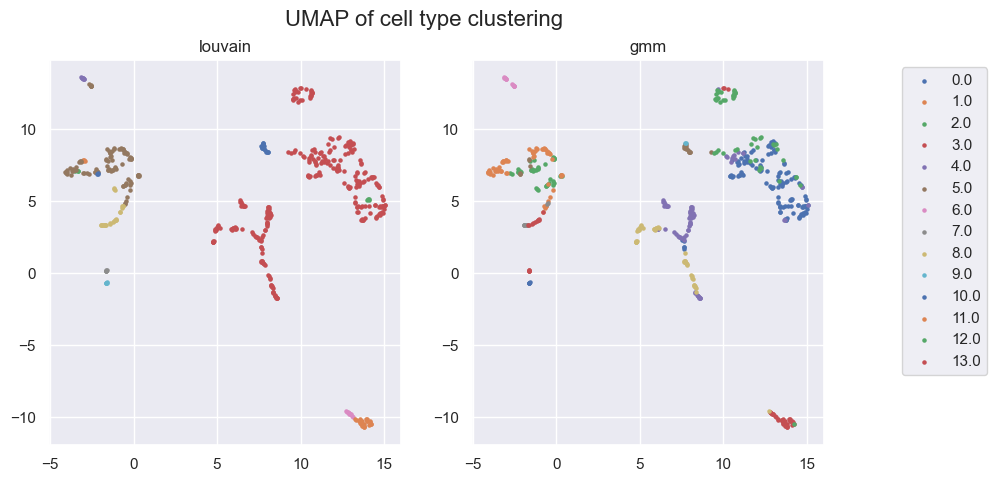

In [ ]:
puF.plot_umap(data, [membership_arr_louvain, membership_arr_gmm], ['louvain', 'gmm'])

# Get Marker Genes and plot violin plots

Will save a dictonary of marker genes for each cluster and plot violin plots for top 3 genes for each cluster. Requires original data before dimension reduction. Have not tested on this dataset.

In [6]:
membership_arr_gmm = np.load('./scripts/membership_arr_gmm_23.npy')
membership_arr_louvain = np.load('./scripts/membership_arr_louvain_large_k5_t10000_knn.npy')
save_dir = os.path.join(os.getcwd(), 'output')

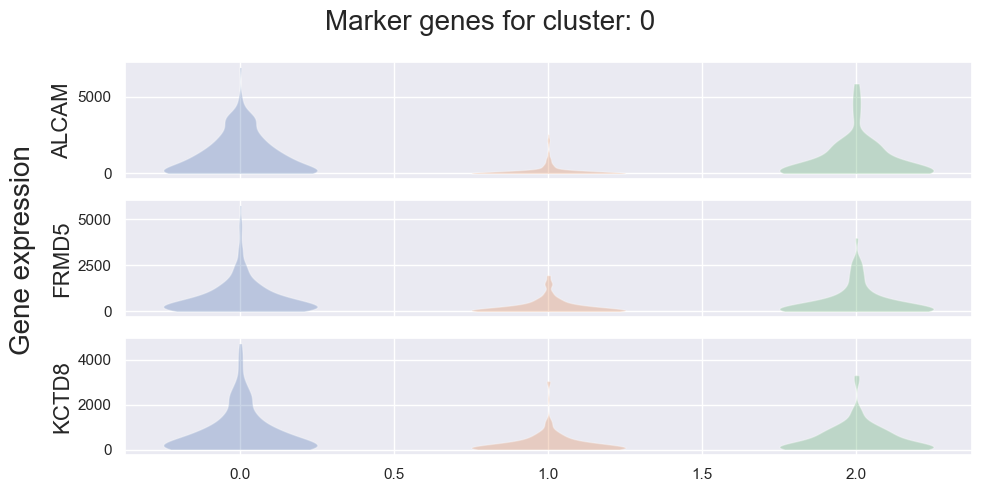

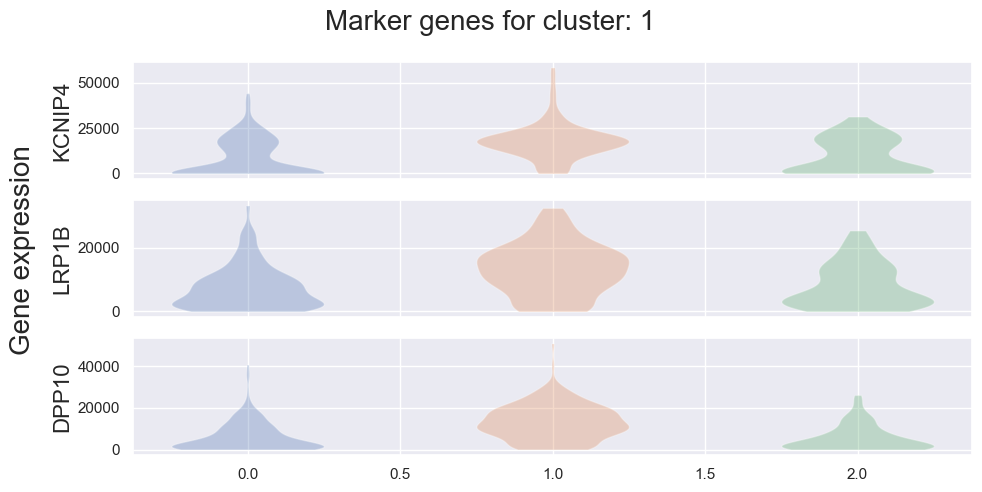

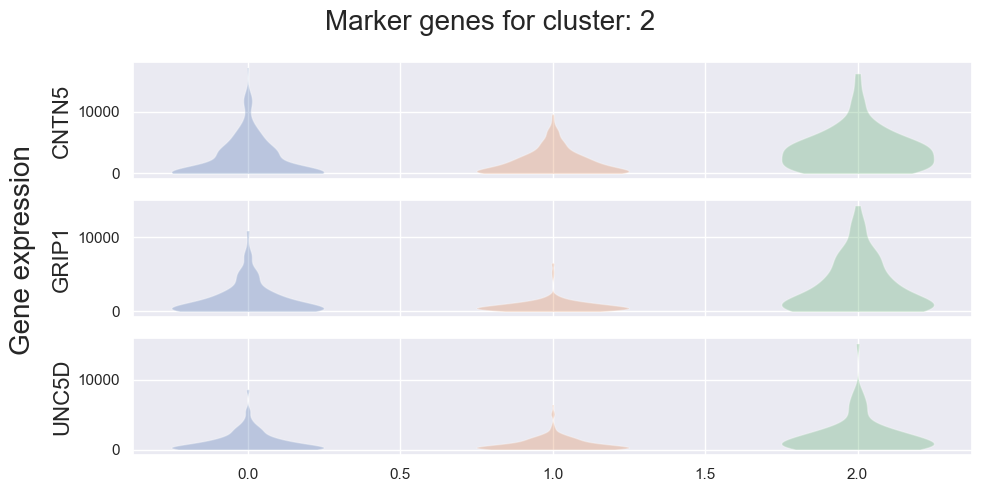

In [12]:
clusters = np.unique(membership_arr_gmm)
median_arr, mean_arr = mgF.get_gene_stats_by_cluster(data_file, membership_arr_louvain.reshape(-1), clusters)
mgF.filter_genes_by_median(median_arr, mean_arr)
mgF.plot_marker_genes(data_file, clusters, membership_arr_louvain.reshape(-1), save_dir = save_dir)

# Evaluate performance

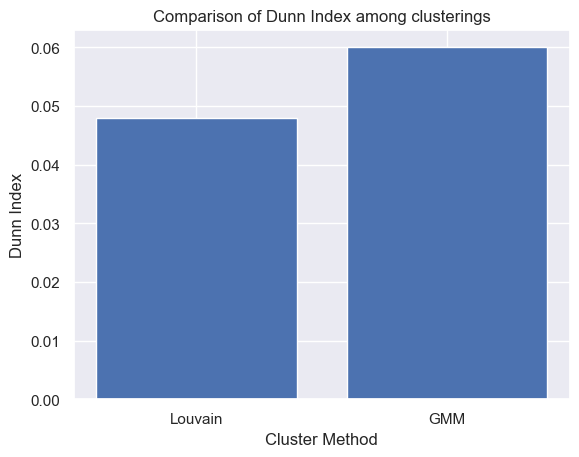

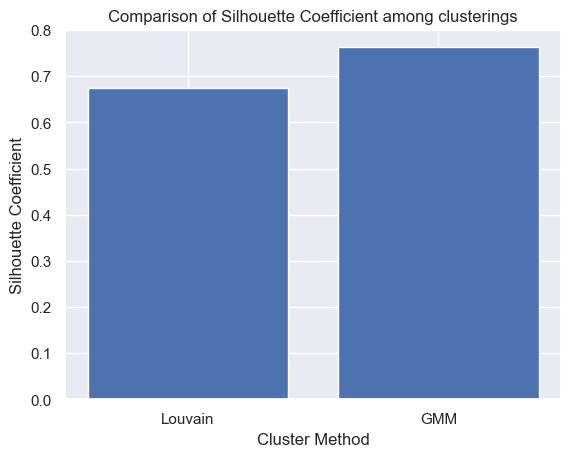

<Figure size 640x480 with 0 Axes>

In [17]:
louvain_centres = ev.calculate_cluster_centroids(membership_arr_louvain, data)
louvain_di = ev.dunn_index(membership_arr_louvain, data, louvain_centres)
louvain_sc = ev.silhouette_coefficient(membership_arr_louvain, data, louvain_centres)

gmm_centres = ev.calculate_cluster_centroids(membership_arr_gmm, data)
gmm_di = ev.dunn_index(membership_arr_gmm, data, gmm_centres)
gmm_sc = ev.silhouette_coefficient(membership_arr_gmm, data, gmm_centres)

di = np.asarray([louvain_di, gmm_di])
sc = [louvain_sc, gmm_sc]

ev.plot_evaluation_metric(di, ['Louvain','GMM'], "Dunn Index", output_folder = './output')
ev.plot_evaluation_metric(
        sc, ['Louvain', 'GMM'], "Silhouette Coefficient", output_folder = './output')

# Gaussian Naive Bayes

In [2]:
dirpath = None
dirpath = r'C:\Users\tzhan\PythonWS\02620_Spring2023\Project' # Path To Directory.
if dirpath is None:
    raise Exception(r'MAKE DIRPATH YOUR DIRECTORY SUCH THAT THE FOLDER "data" IS IN THE DIRECTORY')
os.chdir(dirpath)
#import larger dataset
large_data = np.loadtxt(os.path.join(r'.\scripts','reduced_data_20_PCs.csv'), delimiter=',')
print(large_data.shape)

(16155, 20)


In [3]:
membership_arr_gmm = np.load('./scripts/membership_arr_gmm_23.npy')
membership_arr_louvain = np.load('./scripts/membership_arr_louvain_large_k5_t10000_knn.npy')

In [4]:
# Removing small clusters
mask = np.zeros(large_data.shape[0])
for i in np.unique(membership_arr_gmm):
    cluster_size = np.sum(membership_arr_gmm == i)
    if cluster_size < 10:
        mask += np.where(membership_arr_gmm == i, 1, 0)

for i in np.unique(membership_arr_louvain):
    cluster_size = np.sum(membership_arr_louvain == i)
    if cluster_size < 10:
        mask += np.where(membership_arr_louvain == i, 1, 0)
mask = mask.astype(bool)

membership_arr_gmm = membership_arr_gmm[~mask]
membership_arr_louvain = membership_arr_louvain[~mask]
large_data = large_data[~mask]
print(large_data.shape)

(16016, 20)


In [5]:
# Renumbering clusters for both clustering methods
old_to_new_dict = {}
for i, old in enumerate(np.unique(membership_arr_louvain)):
    old_to_new_dict[old] = i
membership_arr_louvain = np.asarray([old_to_new_dict[x] for x in membership_arr_louvain])

old_to_new_dict = {}
for i, old in enumerate(np.unique(membership_arr_gmm)):
    old_to_new_dict[old] = i
membership_arr_gmm = np.asarray([old_to_new_dict[x] for x in membership_arr_gmm])

In [6]:
print(np.unique(membership_arr_gmm))
print(np.unique(membership_arr_louvain))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]


In [9]:
import importlib
importlib.reload(gnb)
importlib.reload(ev)

#Run GNB on Louvain labels
X = large_data
y = membership_arr_gmm
features = [x for x in range(X.shape[1])]
classes = np.unique(y)

X_train, X_test, y_train, y_test = gnb.train_test_split(X, y, test_size = 0.3, random_state = 0, stratify=y)

priors_data = gnb.calculate_class_priors(y_train)
param = gnb.calculate_param(X_train, y_train)
pred_pca = np.array(gnb.predict(X_test, features, classes, priors_data, param))
print(f"GNB accuracy on {X.shape[0]} points:", gnb.accuracy_score(pred_pca, y_test))

_ = ev.create_global_matrix(y_test, pred_pca, classes, len(classes))

GNB accuracy on 16016 points: 85.56


array([[0.88056206, 0.        , 0.        , 0.0045045 , 0.        ,
        0.00952381, 0.        , 0.00789474, 0.        , 0.        ,
        0.00409836, 0.02386635, 0.        , 0.        , 0.07738095,
        0.        , 0.        , 0.10606061],
       [0.        , 0.93019197, 0.14485981, 0.        , 0.        ,
        0.05714286, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.01515152],
       [0.        , 0.09947644, 0.48598131, 0.        , 0.        ,
        0.01904762, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.11961722, 0.        ,
        0.        , 0.        , 0.00505051],
       [0.        , 0.        , 0.        , 0.89189189, 0.        ,
        0.        , 0.01923077, 0.00789474, 0.        , 0.        ,
        0.01229508, 0.        , 0.08292683, 0.        , 0.01190476,
        0.        , 0.        , 0.02020202],
    

<Figure size 640x480 with 0 Axes>

In [11]:
#predict on large data. Priors_data and Param are from the previous cell.
X_large = large_data
y = np.array([int(n) for n in membership_arr_louvain])
features = [x for x in range(X_large.shape[1])]
classes = np.unique(y)

X_train, X_test, y_train, y_test = gnb.train_test_split(X_large, y, test_size = 0.3, random_state = 0, stratify=y)

priors_data = gnb.calculate_class_priors(y_train)
param = gnb.calculate_param(X_train, y_train)
pred_pca = np.array(gnb.predict(X_test, features, classes, priors_data, param))
print(f"GNB accuracy on {X_large.shape[0]} points:", gnb.accuracy_score(pred_pca, y_test))

_ = ev.create_global_matrix(y_test, pred_pca, classes, len(classes))

GNB accuracy on 16016 points: 80.02


array([[0.88571429, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.00306748, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.00520833, 0.        , 0.        ,
        0.00465116, 0.00677201, 0.        ],
       [0.        , 0.94666667, 0.02439024, 0.        , 0.00666667,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.01226994, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.97560976, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.00225734, 0.        ],
       [0.        , 0.        , 0.02439024, 0.888

<Figure size 640x480 with 0 Axes>